# Import libraries and convert MISP attribute JSON file to dataframe

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

#convert attribute JSON file to dataframe
import pandas as pd
import json
f = open('MISP_attributes_all.json')
data = json.load(f)
data 
dict = data['response']['Attribute']
df_dict = pd.DataFrame.from_dict(dict)

# Number of days for prediction

In [2]:
daynum = 14

# Data prep - All attribution

In [3]:
#extract id,event_id,timestamp
df_all = df_dict[['id','event_id','timestamp']]
#get timestamp and convert unix time to date and drop hours/minutes
df_all = pd.to_datetime(df_all['timestamp'], unit='s').dt.date
#convert object to datetime
df_all = pd.to_datetime(df_all)
#group by date and name headers
df_all = df_all.value_counts().rename_axis('Date').reset_index(name='Num').sort_values(by=['Date']).reset_index(drop=True)
#filter last X days
df_all = df_all[df_all['Date'] > datetime.now() - pd.to_timedelta("1500days")]
#cut outliers
q = df_all.Num.quantile(0.95)
df_all = df_all.query('Num < @q')
print(df_all)

           Date  Num
600  2018-05-10   49
601  2018-05-14  159
602  2018-05-15   25
603  2018-05-22   75
604  2018-05-23  158
...         ...  ...
1036 2022-04-19   51
1037 2022-04-21    6
1038 2022-04-22  118
1039 2022-04-25  138
1040 2022-04-26   26

[418 rows x 2 columns]


# Model - All attribution

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 300)               90600     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 14)                4214      
                                                                 
Total params: 94,814
Trainable params: 94,814
Non-trainable params: 0
_________________________________________________________________


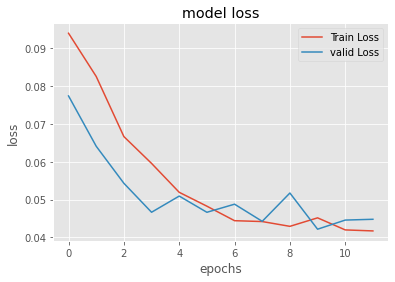

n-step ahead        RMSE        MAE       MAPE
0              1  124.492607  81.925903  10.982151
1              2  136.287231  91.023392   8.272867
2              3  133.272156  87.316841  10.210143
3              4  129.005020  88.712646  11.295169
4              5  128.168808  77.144249   8.863765
5              6  125.651535  79.080078   8.132092
6              7  142.085953  91.239693   7.702648
7              8  138.868729  86.993622   9.239821
8              9  145.081558  88.434357   7.551366
9             10  156.993240  96.048744   7.584494
10            11  139.967773  81.398987   7.661753
11            12  138.132156  85.463150   7.780252
12            13  147.873398  88.375969   7.489978
13            14  131.676651  89.975006   9.448123

In [4]:
#numbers to NumPy
dataset = df_all.Num.values
dataset = dataset.astype('float32')
#1D to 2D
dataset = np.reshape(dataset, (-1, 1))
# create dataset
def gen_dataset(dataset, lag_max, forecast_horizon=1):
    X, y = [], []
    for i in range(len(dataset) - lag_max - forecast_horizon + 1):
        a = i + lag_max
        b = a + forecast_horizon
        X.append(dataset[i:a, 0]) #lag features
        y.append(dataset[a:b, 0]) #objective variable
    return np.array(X), np.array(y)
# create dataset for analysis
lag_max = 150
forecast_horizon = daynum # 14days prediction period
X, y = gen_dataset(dataset, lag_max, forecast_horizon)
test_length = 70 #time period of test data
X_train_0 = X[:-test_length,:] #leaning data
X_test_0 = X[-test_length:,:]  #test data
y_train = y[:-test_length,:] #learning data
y_test = y[-test_length:,:]  #test data
# normalization（0-1）
## objective variable y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
## explanatory variable X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)
# rebuild for model construction (sample number, time steps, features)
X_train = np.reshape(X_train_0, (X_train_0.shape[0],X_train_0.shape[1], 1))
X_test = np.reshape(X_test_0, (X_test_0.shape[0],X_test_0.shape[1], 1))
# settings for each model
models = [
    ['SimpleRNN',
         Sequential([
             SimpleRNN(300,input_shape=(X_train.shape[1], X_train.shape[2])),
             Dropout(0.2),
             Dense(forecast_horizon, activation='linear'),
         ])
    ],
]

for model_name, model in models:
    model.compile(loss='mean_squared_error', optimizer='adam')
    # plot model
    plot_model(model,show_shapes=True)
    # EaelyStopping setting
    early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
    # leaning process
    history = model.fit(X_train, y_train,
                    epochs=2000,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping] ,
                    verbose=0, 
                    shuffle=False)
    # output learning result
    model.summary()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='valid Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    # predict objective variable of test data
    y_test_pred = model.predict(X_test)
    y_test_pred = scaler_y.inverse_transform(y_test_pred)
    # combine test data objective variable and prediction result
    df_test = pd.DataFrame(np.hstack((y_test,y_test_pred)))
    # save Smodel
    filename = model_name + '.h5'
    model.save(filename)

# load model
filename = 'SimpleRNN.h5'
model = load_model(filename)

# predict objective variable of test data
# close to 0 is better
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

#　combine 14 days actual value（y）and predicted value
df_test_last_ALL = pd.DataFrame(y_test[test_length-1], columns = ['y'])
df_test_last_ALL['Predict'] = pd.DataFrame(y_test_pred[test_length-1])
predict_ALL = df_test_last_ALL['Predict'].sum()
na_prev = df_test_last_ALL['y'].sum()
accuracy_ALL = (100 - abs((((na_prev - predict_ALL)/na_prev)*100))).round(1).astype(str)+'%'

# accuracy index for 14days prediction
testResult = []
for i in range(forecast_horizon): 
    RMSE=np.sqrt(mean_squared_error(y_test[:,i], y_test_pred[:,i]))
    MAE=mean_absolute_error(y_test[:,i], y_test_pred[:,i])
    MAPE=mean_absolute_percentage_error(y_test[:,i], y_test_pred[:,i])
    testResult.append([i+1,RMSE,MAE,MAPE])
    
testResult = pd.DataFrame(testResult, columns=(['n-step ahead','RMSE','MAE','MAPE']))
testResult

# Data prep - grouped by Category

In [5]:
#for misp_atr_category
df_cat = df_dict[['id','event_id','timestamp','category']]
#get timestamp and convert unix time to date and drop hours/minutes
df_cat['timestamp'] = pd.to_datetime(df_cat['timestamp'], unit='s').dt.date
#convert object to datetime
df_cat['timestamp'] = pd.to_datetime(df_cat['timestamp'])
df_cat = df_cat.value_counts(['timestamp', 'category']).reset_index(name='Num').sort_values(by=['timestamp'])
print(df_cat['category'].value_counts())

External analysis        840
Network activity         839
Payload delivery         785
Other                    356
Artifacts dropped        333
Payload installation     107
Attribution               68
Antivirus detection       61
Persistence mechanism     54
Financial fraud           20
Support Tool              17
Internal reference        15
Targeting data            15
Social network            11
Person                     4
Payload type               3
Name: category, dtype: int64


# Model - External analysis

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 300)               90600     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                4214      
                                                                 
Total params: 94,814
Trainable params: 94,814
Non-trainable params: 0
_________________________________________________________________


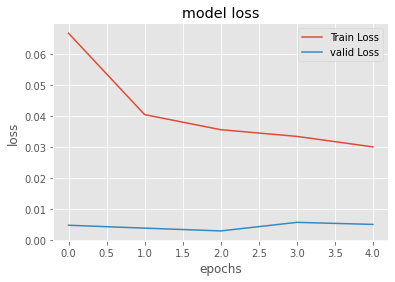

n-step ahead      RMSE       MAE      MAPE
0              1  4.243699  3.914084  2.887895
1              2  5.328138  4.999045  3.783064
2              3  4.503321  4.125656  3.025376
3              4  5.073555  4.765905  3.590621
4              5  5.711355  5.421639  4.012205
5              6  7.494530  5.724370  3.831534
6              7  7.327951  5.493319  3.579152
7              8  7.038144  5.072168  3.389934
8              9  7.456387  5.710189  3.799871
9             10  7.317304  5.428916  3.625260
10            11  6.682169  4.501508  2.832677
11            12  8.330256  7.049939  4.664907
12            13  7.876928  6.423747  4.267050
13            14  6.796888  4.543140  2.889500

In [6]:
df_cat_EA = df_cat[df_cat['category'].str.contains("External analysis")]
#cut outliers
q = df_cat_EA.Num.quantile(0.95)
df_cat_EA = df_cat_EA.query('Num < @q')

#numbers to NumPy
dataset = df_cat_EA.Num.values
dataset = dataset.astype('float32')
#1D to 2D
dataset = np.reshape(dataset, (-1, 1))
# create dataset
def gen_dataset(dataset, lag_max, forecast_horizon=1):
    X, y = [], []
    for i in range(len(dataset) - lag_max - forecast_horizon + 1):
        a = i + lag_max
        b = a + forecast_horizon
        X.append(dataset[i:a, 0]) #lag features
        y.append(dataset[a:b, 0]) #objective variable
    return np.array(X), np.array(y)
# create dataset for analysis
lag_max = 150
forecast_horizon = daynum # 14days prediction period
X, y = gen_dataset(dataset, lag_max, forecast_horizon)
test_length = 70 #time period of test data
X_train_0 = X[:-test_length,:] #leaning data
X_test_0 = X[-test_length:,:]  #test data
y_train = y[:-test_length,:] #learning data
y_test = y[-test_length:,:]  #test data
# normalization（0-1）
## objective variable y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
## explanatory variable X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)
# rebuild for model construction (sample number, time steps, features)
X_train = np.reshape(X_train_0, (X_train_0.shape[0],X_train_0.shape[1], 1))
X_test = np.reshape(X_test_0, (X_test_0.shape[0],X_test_0.shape[1], 1))
# settings for each model
models = [
    ['SimpleRNN',
         Sequential([
             SimpleRNN(300,input_shape=(X_train.shape[1], X_train.shape[2])),
             Dropout(0.2),
             Dense(forecast_horizon, activation='linear'),
         ])
    ],
]

for model_name, model in models:
    model.compile(loss='mean_squared_error', optimizer='adam')
    # plot model
    plot_model(model,show_shapes=True)
    # EaelyStopping setting
    early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
    # leaning process
    history = model.fit(X_train, y_train,
                    epochs=2000,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping] ,
                    verbose=0, 
                    shuffle=False)
    # output learning result
    model.summary()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='valid Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    # predict objective variable of test data
    y_test_pred = model.predict(X_test)
    y_test_pred = scaler_y.inverse_transform(y_test_pred)
    # combine test data objective variable and prediction result
    df_test = pd.DataFrame(np.hstack((y_test,y_test_pred)))
    # save Smodel
    filename = model_name + '.h5'
    model.save(filename)

# load model
filename = 'SimpleRNN.h5'
model = load_model(filename)

# predict objective variable of test data
# close to 0 is better
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

df_test_last_EA = pd.DataFrame(y_test[test_length-1], columns = ['y'])
df_test_last_EA['Predict'] = pd.DataFrame(y_test_pred[test_length-1])
predict_EA = df_test_last_EA['Predict'].sum()
na_prev = df_test_last_EA['y'].sum()
accuracy_EA = (100 - abs((((na_prev - predict_EA)/na_prev)*100))).round(1).astype(str)+'%'

# accuracy index for 14days prediction
testResult = []
for i in range(forecast_horizon): 
    RMSE=np.sqrt(mean_squared_error(y_test[:,i], y_test_pred[:,i]))
    MAE=mean_absolute_error(y_test[:,i], y_test_pred[:,i])
    MAPE=mean_absolute_percentage_error(y_test[:,i], y_test_pred[:,i])
    testResult.append([i+1,RMSE,MAE,MAPE])
    
testResult = pd.DataFrame(testResult, columns=(['n-step ahead','RMSE','MAE','MAPE']))
testResult

# Model - Network activity

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 300)               90600     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 14)                4214      
                                                                 
Total params: 94,814
Trainable params: 94,814
Non-trainable params: 0
_________________________________________________________________


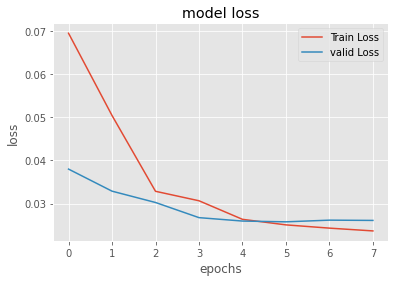

n-step ahead       RMSE        MAE       MAPE
0              1  78.098801  44.909729   8.016643
1              2  76.969826  42.324837   6.345946
2              3  78.339798  42.741016   7.299181
3              4  79.589424  48.677837   8.852902
4              5  78.263382  45.174889   7.481891
5              6  81.122200  50.441605  10.134286
6              7  84.291245  57.159355  10.032986
7              8  77.805328  42.643188   7.118518
8              9  78.006905  48.953091   9.031535
9             10  74.715416  45.696785   8.019798
10            11  74.928619  42.420895   7.689393
11            12  71.611092  39.088085   6.872847
12            13  74.131866  38.463459   6.990084
13            14  72.599449  40.476963   6.664995

In [7]:
df_cat_NA = df_cat[df_cat['category'].str.contains("Network activity")]
q = df_cat_NA.Num.quantile(0.95)
df_cat_NA = df_cat_NA.query('Num < @q')

#numbers to NumPy
dataset = df_cat_NA.Num.values
dataset = dataset.astype('float32')
#1D to 2D
dataset = np.reshape(dataset, (-1, 1))
# create dataset
def gen_dataset(dataset, lag_max, forecast_horizon=1):
    X, y = [], []
    for i in range(len(dataset) - lag_max - forecast_horizon + 1):
        a = i + lag_max
        b = a + forecast_horizon
        X.append(dataset[i:a, 0]) #lag features
        y.append(dataset[a:b, 0]) #objective variable
    return np.array(X), np.array(y)
# create dataset for analysis
lag_max = 150
forecast_horizon = daynum # 14days prediction period
X, y = gen_dataset(dataset, lag_max, forecast_horizon)
test_length = 70 #time period of test data
X_train_0 = X[:-test_length,:] #leaning data
X_test_0 = X[-test_length:,:]  #test data
y_train = y[:-test_length,:] #learning data
y_test = y[-test_length:,:]  #test data
# normalization（0-1）
## objective variable y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
## explanatory variable X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)
# rebuild for model construction (sample number, time steps, features)
X_train = np.reshape(X_train_0, (X_train_0.shape[0],X_train_0.shape[1], 1))
X_test = np.reshape(X_test_0, (X_test_0.shape[0],X_test_0.shape[1], 1))
# settings for each model
models = [
    ['SimpleRNN',
         Sequential([
             SimpleRNN(300,input_shape=(X_train.shape[1], X_train.shape[2])),
             Dropout(0.2),
             Dense(forecast_horizon, activation='linear'),
         ])
    ],
]

for model_name, model in models:
    model.compile(loss='mean_squared_error', optimizer='adam')
    # plot model
    plot_model(model,show_shapes=True)
    # EaelyStopping setting
    early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
    # leaning process
    history = model.fit(X_train, y_train,
                    epochs=2000,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping] ,
                    verbose=0, 
                    shuffle=False)
    # output learning result
    model.summary()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='valid Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    # predict objective variable of test data
    y_test_pred = model.predict(X_test)
    y_test_pred = scaler_y.inverse_transform(y_test_pred)
    # combine test data objective variable and prediction result
    df_test = pd.DataFrame(np.hstack((y_test,y_test_pred)))
    # save Smodel
    filename = model_name + '.h5'
    model.save(filename)

# load model
filename = 'SimpleRNN.h5'
model = load_model(filename)

# predict objective variable of test data
# close to 0 is better
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

df_test_last_NA = pd.DataFrame(y_test[test_length-1], columns = ['y'])
df_test_last_NA['Predict'] = pd.DataFrame(y_test_pred[test_length-1])
predict_NA = df_test_last_NA['Predict'].sum()
na_prev = df_test_last_NA['y'].sum()
accuracy_NA = (100 - abs((((na_prev - predict_NA)/na_prev)*100))).round(1).astype(str)+'%'

# accuracy index for 14days prediction
testResult = []
for i in range(forecast_horizon): 
    RMSE=np.sqrt(mean_squared_error(y_test[:,i], y_test_pred[:,i]))
    MAE=mean_absolute_error(y_test[:,i], y_test_pred[:,i])
    MAPE=mean_absolute_percentage_error(y_test[:,i], y_test_pred[:,i])
    testResult.append([i+1,RMSE,MAE,MAPE])
    
testResult = pd.DataFrame(testResult, columns=(['n-step ahead','RMSE','MAE','MAPE']))
testResult

# Model - Payload delivery

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 300)               90600     
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 14)                4214      
                                                                 
Total params: 94,814
Trainable params: 94,814
Non-trainable params: 0
_________________________________________________________________


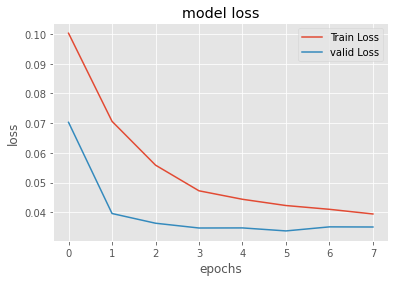

n-step ahead       RMSE        MAE      MAPE
0              1  42.013199  32.810589  3.822941
1              2  42.749149  33.142799  3.749117
2              3  45.826992  35.365314  3.905149
3              4  44.922333  34.616192  3.549064
4              5  44.246643  31.420351  2.974623
5              6  42.199421  31.217188  3.184336
6              7  40.651909  31.706589  3.249900
7              8  39.414856  28.471834  2.693258
8              9  42.497734  33.486176  4.089597
9             10  38.536369  28.718771  3.081528
10            11  37.455177  28.624611  3.817781
11            12  40.736835  30.929890  3.324359
12            13  36.811996  26.962410  3.649958
13            14  35.527798  25.399673  2.914119

In [8]:
df_cat_PD = df_cat[df_cat['category'].str.contains("Payload delivery")]
q = df_cat_NA.Num.quantile(0.95)
df_cat_PD = df_cat_PD.query('Num < @q')

#numbers to NumPy
dataset = df_cat_PD.Num.values
dataset = dataset.astype('float32')
#1D to 2D
dataset = np.reshape(dataset, (-1, 1))

# create dataset
def gen_dataset(dataset, lag_max, forecast_horizon=1):
    X, y = [], []
    for i in range(len(dataset) - lag_max - forecast_horizon + 1):
        a = i + lag_max
        b = a + forecast_horizon
        X.append(dataset[i:a, 0]) #lag features
        y.append(dataset[a:b, 0]) #objective variable
    return np.array(X), np.array(y)

# create dataset for analysis
lag_max = 150
forecast_horizon = daynum # 14days prediction period
X, y = gen_dataset(dataset, lag_max, forecast_horizon)
test_length = 70 #time period of test data
X_train_0 = X[:-test_length,:] #leaning data
X_test_0 = X[-test_length:,:]  #test data
y_train = y[:-test_length,:] #learning data
y_test = y[-test_length:,:]  #test data
# normalization（0-1）
## objective variable y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
## explanatory variable X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)
# rebuild for model construction (sample number, time steps, features)
X_train = np.reshape(X_train_0, (X_train_0.shape[0],X_train_0.shape[1], 1))
X_test = np.reshape(X_test_0, (X_test_0.shape[0],X_test_0.shape[1], 1))
# settings for each model

models = [
    ['SimpleRNN',
         Sequential([
             SimpleRNN(300,input_shape=(X_train.shape[1], X_train.shape[2])),
             Dropout(0.2),
             Dense(forecast_horizon, activation='linear'),
         ])
    ],
]

for model_name, model in models:
    model.compile(loss='mean_squared_error', optimizer='adam')
    # plot model
    plot_model(model,show_shapes=True)
    # EaelyStopping setting
    early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
    # leaning process
    history = model.fit(X_train, y_train,
                    epochs=2000,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping] ,
                    verbose=0, 
                    shuffle=False)
    # output learning result
    model.summary()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='valid Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    # predict objective variable of test data
    y_test_pred = model.predict(X_test)
    y_test_pred = scaler_y.inverse_transform(y_test_pred)
    # combine test data objective variable and prediction result
    df_test = pd.DataFrame(np.hstack((y_test,y_test_pred)))
    # save Smodel
    filename = model_name + '.h5'
    model.save(filename)

# load model
filename = 'SimpleRNN.h5'
model = load_model(filename)

# predict objective variable of test data
# close to 0 is better
y_test_pred = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred)

df_test_last_PD = pd.DataFrame(y_test[test_length-1], columns = ['y'])
df_test_last_PD['Predict'] = pd.DataFrame(y_test_pred[test_length-1])
predict_PD = df_test_last_PD['Predict'].sum()
na_prev = df_test_last_PD['y'].sum()
accuracy_PD = (100 - abs((((na_prev - predict_PD)/na_prev)*100))).round(1).astype(str)+'%'

# accuracy index for 14days prediction
testResult = []
for i in range(forecast_horizon): 
    RMSE=np.sqrt(mean_squared_error(y_test[:,i], y_test_pred[:,i]))
    MAE=mean_absolute_error(y_test[:,i], y_test_pred[:,i])
    MAPE=mean_absolute_percentage_error(y_test[:,i], y_test_pred[:,i])
    testResult.append([i+1,RMSE,MAE,MAPE])
    
testResult = pd.DataFrame(testResult, columns=(['n-step ahead','RMSE','MAE','MAPE']))
testResult

# Output combined prediction values

In [9]:
last_ALL = df_all['Num'].tail(daynum).sum()
last_EA = df_cat_EA['Num'].tail(daynum).sum()
last_NA = df_cat_NA['Num'].tail(daynum).sum()
last_PD = df_cat_PD['Num'].tail(daynum).sum()

pred_value = [[last_ALL, int(predict_ALL), accuracy_ALL], [last_EA, int(predict_EA), accuracy_EA], [last_NA, int(predict_NA), accuracy_NA], [last_PD, int(predict_PD), accuracy_PD]]
index = ["All attributes", "External analysis","Network activity", "Payload delivery"]
column = ["numbers_last_14days","predicted_numbers_14days", "prediction_accuracy"]
Prediction_table = pd.DataFrame(data=pred_value, index=index, columns=column).sort_values(by=['predicted_numbers_14days'], ascending=False)
Prediction_table['predicted_change'] = Prediction_table[['numbers_last_14days', 'predicted_numbers_14days']].pct_change(axis=1).mul(100).round(1)['predicted_numbers_14days']
Prediction_table['predicted_change'] = Prediction_table['predicted_change'].astype(str)+'%'
Prediction_table = Prediction_table[['numbers_last_14days', 'predicted_numbers_14days', 'predicted_change', 'prediction_accuracy']]
Prediction_table.index.name='attribute'
Prediction_table = Prediction_table.reset_index(level=0)
Prediction_table

attribute  numbers_last_14days  predicted_numbers_14days  \
0     All attributes                 1579                      1054   
1   Network activity                  419                       811   
2   Payload delivery                  422                       534   
3  External analysis                   91                        94   

  predicted_change prediction_accuracy  
0           -33.2%               66.8%  
1            93.6%                6.3%  
2            26.5%               73.3%  
3             3.3%               95.7%

# Output prediction graph

C:\Users\kamioki\AppData\Local\Temp/ipykernel_32760/775690050.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 432x288 with 0 Axes>

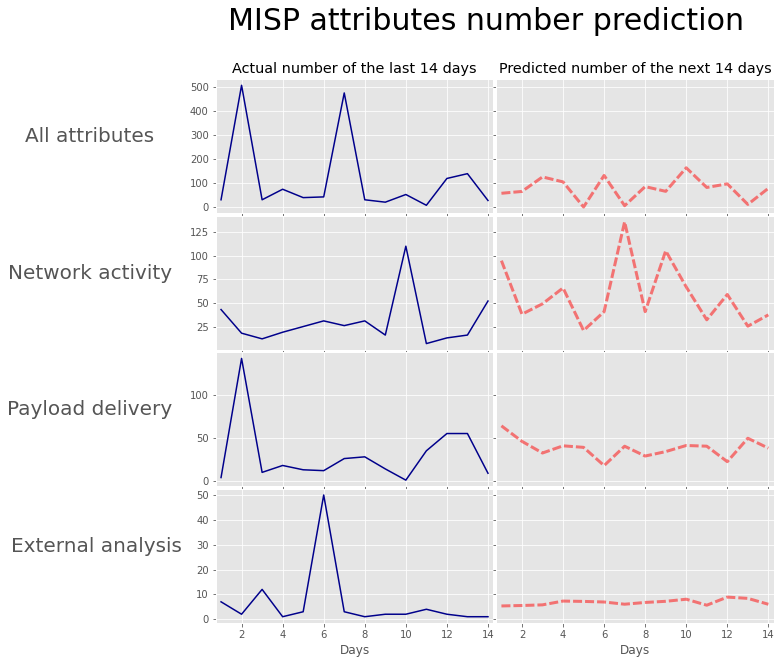

In [10]:
fig = plt.figure()
plt.rcParams['axes.xmargin'] = 0.02
#plt.rcParams['axes.facecolor']='whitesmoke'
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey='row', gridspec_kw={'hspace': 0.02,'wspace': 0.01})
x = np.linspace(1, daynum, daynum)

c1,c2 = "darkblue","red"      # colours
axes[0,0].plot(x, df_all['Num'].tail(daynum), color=c1)
axes[0,1].plot(x, df_test_last_ALL['Predict'], color=c2, alpha=0.5,linewidth=3,linestyle='--', dashes=(3, 1))
axes[1,0].plot(x, df_cat_NA['Num'].tail(daynum), color=c1)
axes[1,1].plot(x, df_test_last_NA['Predict'], color=c2, alpha=0.5,linewidth=3,linestyle='--', dashes=(3, 1))
axes[2,0].plot(x, df_cat_PD['Num'].tail(daynum), color=c1)
axes[2,1].plot(x, df_test_last_PD['Predict'], color=c2, alpha=0.5,linewidth=3,linestyle='--', dashes=(3, 1))
axes[3,0].plot(x, df_cat_EA['Num'].tail(daynum), color=c1)
axes[3,1].plot(x, df_test_last_EA['Predict'], color=c2, alpha=0.5,linewidth=3,linestyle='--', dashes=(3, 1))
fig.suptitle("MISP attributes number prediction", fontsize=30)
fig.subplots_adjust(top=0.88)
axes[0,0].set_title("Actual number of the last 14 days")
axes[0,0].set_ylabel('All attributes', rotation=0, fontsize=20, labelpad=100)
axes[1,0].set_ylabel('Network activity', rotation=0, fontsize=20, labelpad=100)
axes[2,0].set_ylabel('Payload delivery', rotation=0, fontsize=20, labelpad=100)
axes[3,0].set_ylabel('External analysis', rotation=0, fontsize=20, labelpad=100)
axes[3,0].set_xlabel('Days')
axes[3,1].set_xlabel('Days')
axes[0,1].set_title("Predicted number of the next 14 days")
fig.tight_layout()
plt.show()
#output png file if needed
#fig.savefig('attributes_prediction.png', facecolor="white",bbox_inches='tight')

In [11]:
######### Export to SQL DB ###########
import os
from sqlalchemy import create_engine
# Database connection credentials
username = os.environ.get('MySQLroot')
password = os.environ.get('MySQLrootpw')
hostname = 'localhost'
dbname = 'securemation'
# Create SQLAlchemy engine to connect to mySQL db
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
                       .format(host=hostname, db=dbname, user=username, pw=password))
Prediction_table.to_sql('misp_prediction', engine,
                        index=False, if_exists='replace')

ModuleNotFoundError: No module named 'pymysql'